In [31]:
# import other files
%run validation.ipynb

# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [32]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers

In [33]:
# import data from "nba_data_collection" stage
all_nba_df = pd.read_csv('./data/all_stats_2000_23.csv')

# clean up the unuseful columns
all_nba_df = all_nba_df.drop(['NICKNAME', 'TEAM_ID', 'NBA_FANTASY_PTS', 'WNBA_FANTASY_PTS', 'NBA_FANTASY_PTS_RANK', 'WNBA_FANTASY_PTS_RANK'], axis=1)

# we are trying to predict the NBA 2022-23 MVP, so isolate this season out
nba_2023 = pd.read_csv('./data/all_stats_2000_23.csv')
nba_2023 = nba_2023[(nba_2023['season_id']== '2022-23')].reset_index(drop=True)
# import team stats to get Game Played stats
team_stats_2022_23_df = pd.read_csv('./data/team_stats_2022_23.csv')
team_stats_2022_23_df = team_stats_2022_23_df[['TEAM_ID', 'GP']]
team_stats_2022_23_df = team_stats_2022_23_df.rename({'GP': 'team_GP'}, axis=1)

nba_2023 = pd.merge(nba_2023, team_stats_2022_23_df, left_on = ['TEAM_ID'], right_on = ['TEAM_ID'], how = 'left')
nba_2023['GP_PCT'] = nba_2023['GP']/nba_2023['team_GP']
nba_2023 = nba_2023.drop(['NICKNAME', 'TEAM_ID', 'GP','NBA_FANTASY_PTS', 'WNBA_FANTASY_PTS', 'NBA_FANTASY_PTS_RANK', 'WNBA_FANTASY_PTS_RANK', 'team_GP'], axis=1)

In [34]:
past_mvps = pd.read_csv('./data/past_mvps_2000_22.csv')
past_mvps = past_mvps[['Player', 'season_id', 'Share']]

# left join all nba stats and mvp results
nba_2000_22 = all_nba_df[(all_nba_df['season_id']!= '2022-23')].reset_index(drop=True)
nba_2000_22 = pd.merge(nba_2000_22, past_mvps, left_on = ['PLAYER_NAME', 'season_id'], right_on = ['Player', 'season_id'], how = 'left')
nba_2000_22['GP_PCT'] = nba_2000_22['GP']/82
nba_2000_22 = nba_2000_22.drop(['Player', 'GP'], axis=1)
nba_2000_22['Share'] = nba_2000_22['Share'].fillna(0.000)

In [35]:
# since there are approx. 450 players in the NBA per season, but not all are qualified for MVP selection. We use past MVP's lowest stats to filter players out
# the stats we are using are the ones that show the impact of players on their teams
# Filter:
# winning percentage: lowest winning percentage on MVP's team in the past is 45.3%
# minutes per game: lowest minutes per game for a MVP is 30.4 min
# GP: lowest game played for an MVP per season is 49 per game
# +/-: lowest +/- for an MVP is 3.1
# offensive rating: lowest offensive rating is 104.7
# defensive rating: highest defensive rating is 110.6
# since we might mis-filter past MVPs out so if they had MVP shares, we still keep the players
# &(nba_2000_22['OFF_RATING'] >= 104.7)&(nba_2000_22['DEF_RATING'] <= 110.6)
filtered_nba_2000_22 = nba_2000_22[((nba_2000_22['W_PCT'] >= 0.453)&
                                    (nba_2000_22['MIN'] >= 30.4)&
                                    (nba_2000_22['GP_PCT'] >= 0.5976)&
                                    (nba_2000_22['PLUS_MINUS'] >= 3.1)&
                                    (nba_2000_22['OFF_RATING'] >= 104.7)&
                                    (nba_2000_22['DEF_RATING'] <= 110.6))|(nba_2000_22['Share']>0)].reset_index(drop=True)
nba_2023 = nba_2023[((nba_2023['W_PCT'] >= 0.453)&
                     (nba_2023['MIN'] >= 30.4)&
                     (nba_2023['GP_PCT'] >= 0.5976)&
                     (nba_2023['PLUS_MINUS'] >= 3.1))].reset_index(drop=True)
nba_2023_model = nba_2023.drop(['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ABBREVIATION', 'season_id'], axis = 1)

In [36]:
# split training and testing data set 
# training: 2000-2018, testing: 2019-2022, predict: 2023
# training
nba_2000_18 = filtered_nba_2000_22.loc[(filtered_nba_2000_22['season_id'] != '2019-20') 
                         & (filtered_nba_2000_22['season_id'] != '2020-21')
                         & (filtered_nba_2000_22['season_id'] != '2021-22')]

share_2000_18 = nba_2000_18[['Share']].values.ravel()
nba_2000_18_model = nba_2000_18.drop(['Share', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ABBREVIATION', 'season_id'], axis = 1)

# testing
nba_2019_22 = filtered_nba_2000_22.loc[(filtered_nba_2000_22['season_id'] == '2019-20') 
                         | (filtered_nba_2000_22['season_id'] == '2020-21')
                         | (filtered_nba_2000_22['season_id'] == '2021-22')]
share_2019_22 = nba_2019_22[['Share']].values.ravel()
nba_2019_22_model = nba_2019_22.drop(['Share', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ABBREVIATION', 'season_id'], axis = 1)

In [37]:
# Assuming that X and y are already defined and X is a pandas DataFrame
# StandardScaler
scaler = StandardScaler()
scaler.fit(nba_2000_18_model)
nba_2000_18_scaled = scaler.transform(nba_2000_18_model)
nba_2019_22_scaled = scaler.transform(nba_2019_22_model)
nba_2023_scaled = scaler.transform(nba_2023_model)

# SelectKBest
k = 20 # number of top features to select
selector = SelectKBest(f_regression, k=k)
selector.fit(nba_2000_18_scaled, share_2000_18)
nba_2000_18_new = selector.transform(nba_2000_18_scaled)
nba_2019_22_new = selector.transform(nba_2019_22_scaled)
nba_2023_new = selector.transform(nba_2023_scaled)

# Get the p-values and F-scores of the selected features
p_values = selector.pvalues_
f_scores = selector.scores_
selected_features = nba_2000_18_model.columns[selector.get_support()]

# Print the selected feature names, F-scores and p-values
# for feature, f_score, p_value in zip(selected_features, f_scores, p_values):
#    print(f"Feature: {feature}, F-score: {f_score:.2f}, p-value: {p_value:.2g}")

In [66]:
selected_features

Index(['FGM', 'FGA', 'FTM', 'FTA', 'TOV', 'PTS', 'DD2', 'FGM_RANK', 'TOV_RANK',
       'PTS_RANK', 'AST_PCT', 'USG_PCT', 'E_USG_PCT', 'PIE', 'FGM_PG',
       'FGA_PG', 'USG_PCT_RANK', 'E_USG_PCT_RANK', 'FGM_PG_RANK',
       'FGA_PG_RANK'],
      dtype='object')

In [38]:
# create an empty dictionary to store the prediction results
test_values = {}
trained_models = {}

In [51]:
# Support Vector Regression 
param_grid = {'C': [0.001,0.01,0.1,0.5,1,2,5,10],
             'kernel': ['linear','rbf','poly'],
             'gamma': ['scale','auto'],
             'degree': [2,3,4],
             'epsilon': [0.1,0.5,1]}
model_svr = SVR()
grid = GridSearchCV(model_svr, param_grid)
grid.fit(nba_2000_18_new, share_2000_18)

# train SVR
model_svr.fit(nba_2000_18_new, share_2000_18)
trained_models['SVR'] = model_svr

# get test set values
y_pred_svr = model_svr.predict(nba_2019_22_new)
y_pred_svr = np.clip(y_pred_svr, 0, 1)
test_values['SVR'] = y_pred_svr

Using 566 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 78/78 [29:13<00:00, 22.48s/it]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


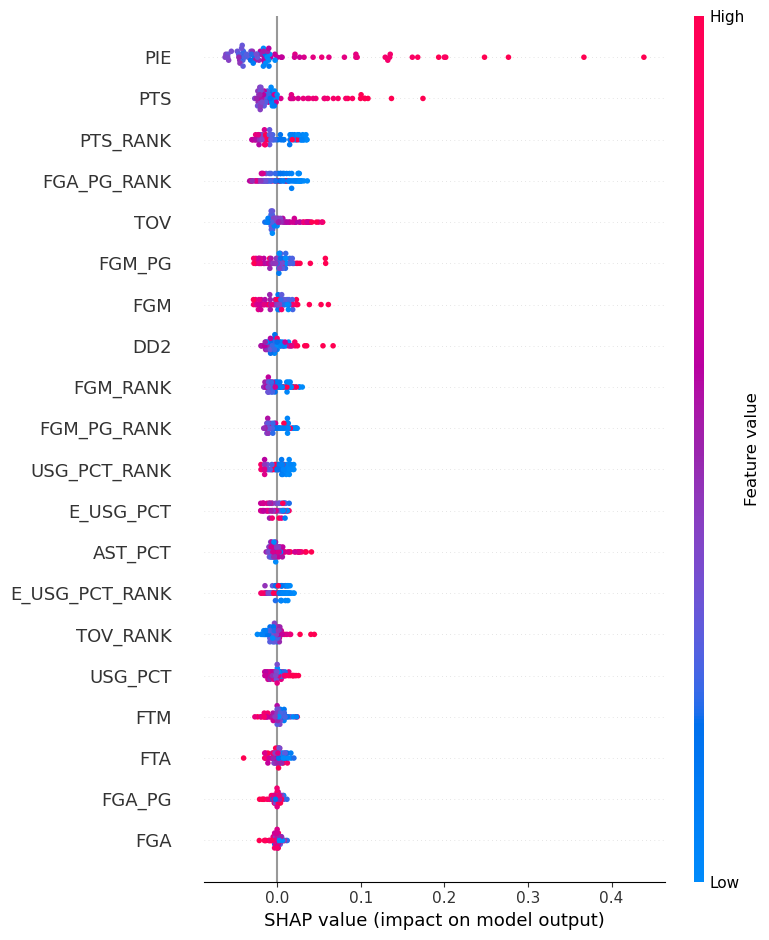

In [73]:
explainer = shap.KernelExplainer(model_svr.predict, nba_2000_18_new)
shap_rf = explainer.shap_values(nba_2019_22_new)
df = pd.DataFrame(nba_2019_22_new, columns=['FGM', 'FGA', 'FTM', 'FTA', 'TOV', 'PTS', 'DD2', 'FGM_RANK', 'TOV_RANK',
       'PTS_RANK', 'AST_PCT', 'USG_PCT', 'E_USG_PCT', 'PIE', 'FGM_PG',
       'FGA_PG', 'USG_PCT_RANK', 'E_USG_PCT_RANK', 'FGM_PG_RANK',
       'FGA_PG_RANK'])
feature_names = list(df.columns)
shap.summary_plot(shap_rf, df, feature_names=feature_names)

In [41]:
# Gradient Boosting
param_grid = {'n_estimators': [10,20,30,40,50],
                             'learning_rate': [0.01,0.05,0.1,0.2,0.5],
                             'max_depth': [3,4,5]}
gb_model = GradientBoostingRegressor()
grid = GridSearchCV(gb_model, param_grid)
grid.fit(nba_2000_18_new, share_2000_18)
model_gb = GradientBoostingRegressor(**grid.best_params_)


# train Gradient Boosting
model_gb.fit(nba_2000_18_new, share_2000_18)
trained_models['Gradient Boosting'] = model_gb

# get test set values
y_pred_gb = model_gb.predict(nba_2019_22_new)
test_values['Gradient Boosting'] = y_pred_gb

Using 566 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 78/78 [04:49<00:00,  3.71s/it]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


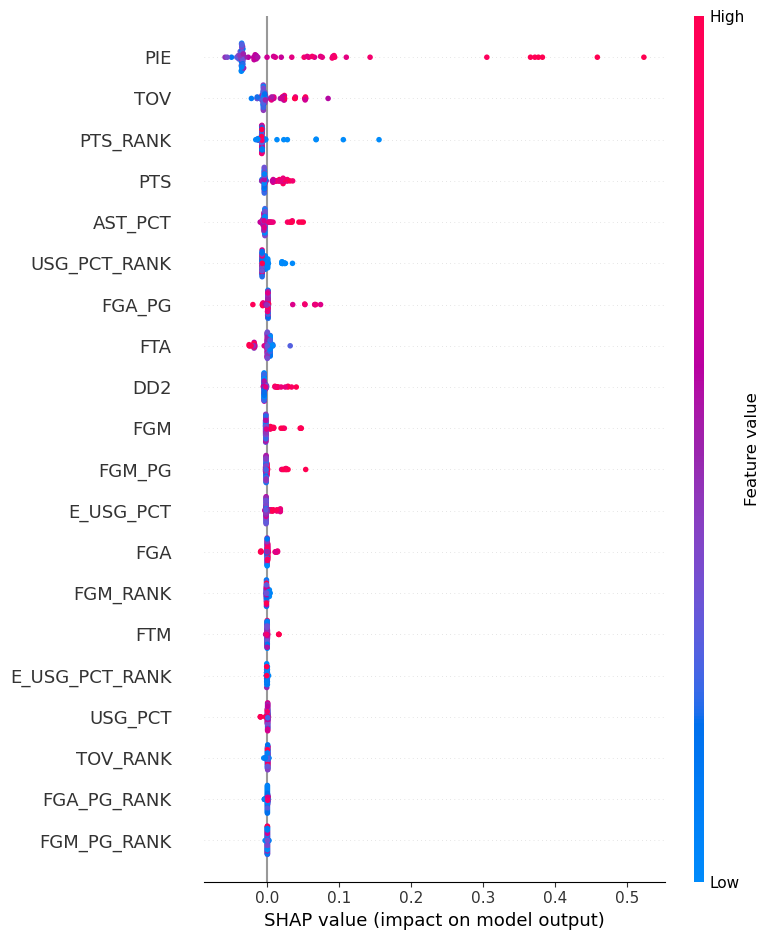

In [70]:
explainer = shap.KernelExplainer(model_gb.predict, nba_2000_18_new)
shap_gb = explainer.shap_values(nba_2019_22_new)
df = pd.DataFrame(nba_2019_22_new, columns=['FGM', 'FGA', 'FTM', 'FTA', 'TOV', 'PTS', 'DD2', 'FGM_RANK', 'TOV_RANK',
       'PTS_RANK', 'AST_PCT', 'USG_PCT', 'E_USG_PCT', 'PIE', 'FGM_PG',
       'FGA_PG', 'USG_PCT_RANK', 'E_USG_PCT_RANK', 'FGM_PG_RANK',
       'FGA_PG_RANK'])
feature_names = list(df.columns)
shap.summary_plot(shap_gb, df, feature_names=feature_names)

In [42]:
# Random Forest
param_grid = {'n_estimators': [15,25,50,64,100,150,200],
                             'max_features': [2,3,4,5],
                             'bootstrap': [True,False],
                             'oob_score': [True,False]}
rfc = RandomForestRegressor()
grid = GridSearchCV(rfc, param_grid)
grid.fit(nba_2000_18_new, share_2000_18)
model_rf = RandomForestRegressor(**grid.best_params_)


model_rf.fit(nba_2000_18_new, share_2000_18)
trained_models['Random Forest'] = model_rf

# get test set values
y_pred_rf = model_rf.predict(nba_2019_22_new)
test_values['Random Forest'] = y_pred_rf

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probabl

In [60]:
explainer = shap.KernelExplainer(model_rf.predict, nba_2000_18_new)
shap_rf = explainer.shap_values(nba_2019_22_new)
df = pd.DataFrame(nba_2019_22_new, columns=['FGM', 'FGA', 'FTM', 'FTA', 'TOV', 'PTS', 'DD2', 'FGM_RANK', 'TOV_RANK',
       'PTS_RANK', 'AST_PCT', 'USG_PCT', 'E_USG_PCT', 'PIE', 'FGM_PG',
       'FGA_PG', 'USG_PCT_RANK', 'E_USG_PCT_RANK', 'FGM_PG_RANK',
       'FGA_PG_RANK'])
feature_names = list(df.columns)
shap.summary_plot(shap_rf, df, feature_names=feature_names)

Using 566 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 78/78 [07:21<00:00,  5.66s/it]


In [55]:
# NN
# Define the neural network architecture
df_shape = nba_2000_18_new.shape[1]

# layers of NN
model_nn = keras.models.Sequential([keras.layers.Dense(64, activation='relu',input_shape=(df_shape,), kernel_regularizer=regularizers.l2(0.001))])
model_nn.add(layers.Dense(1, activation='linear'))

# Compile the model
model_nn.compile(optimizer='adam', loss='mse')

# Train the model
model_nn.fit(nba_2000_18_new, share_2000_18, epochs=100)
trained_models['Neural Network'] = model_nn

# get test set values
y_pred_nn = model_nn.predict(nba_2019_22_new)
y_pred_nn = y_pred_nn.reshape((nba_2019_22_new.shape[0],))
test_values['Neural Network'] = y_pred_nn

Epoch 1/100
18/18 [==============================] - 0s 768us/step - loss: 0.1877
Epoch 2/100
18/18 [==============================] - 0s 644us/step - loss: 0.0981
Epoch 3/100
18/18 [==============================] - 0s 694us/step - loss: 0.0750
Epoch 4/100
18/18 [==============================] - 0s 687us/step - loss: 0.0681
Epoch 5/100
18/18 [==============================] - 0s 756us/step - loss: 0.0646
Epoch 6/100
18/18 [==============================] - 0s 659us/step - loss: 0.0611
Epoch 7/100
18/18 [==============================] - 0s 616us/step - loss: 0.0590
Epoch 8/100
18/18 [==============================] - 0s 609us/step - loss: 0.0571
Epoch 9/100
18/18 [==============================] - 0s 737us/step - loss: 0.0557
Epoch 10/100
18/18 [==============================] - 0s 707us/step - loss: 0.0567
Epoch 11/100
18/18 [==============================] - 0s 686us/step - loss: 0.0537
Epoch 12/100
18/18 [==============================] - 0s 634us/step - loss: 0.0523
Epoch 13/100


18/18 [==============================] - 0s 509us/step


Using 566 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/78 [00:00<?, ?it/s]

36932/36932 [==============================] - 13s 346us/step


  1%|▏         | 1/78 [00:24<32:01, 24.96s/it]

36932/36932 [==============================] - 13s 346us/step


  3%|▎         | 2/78 [00:46<29:02, 22.92s/it]

36932/36932 [==============================] - 13s 354us/step


  4%|▍         | 3/78 [01:08<28:00, 22.41s/it]

36932/36932 [==============================] - 13s 362us/step


  5%|▌         | 4/78 [01:30<27:27, 22.27s/it]

36932/36932 [==============================] - 14s 368us/step


  6%|▋         | 5/78 [01:52<27:10, 22.33s/it]

36932/36932 [==============================] - 13s 348us/step


  8%|▊         | 6/78 [02:14<26:43, 22.27s/it]

36932/36932 [==============================] - 13s 347us/step


  9%|▉         | 7/78 [02:36<26:02, 22.00s/it]

36932/36932 [==============================] - 13s 343us/step


 10%|█         | 8/78 [02:57<25:28, 21.83s/it]

36932/36932 [==============================] - 13s 340us/step


 12%|█▏        | 9/78 [03:19<24:53, 21.64s/it]

36932/36932 [==============================] - 13s 353us/step


 13%|█▎        | 10/78 [03:40<24:35, 21.70s/it]

36932/36932 [==============================] - 13s 343us/step


 14%|█▍        | 11/78 [04:02<24:06, 21.59s/it]

36932/36932 [==============================] - 13s 352us/step


 15%|█▌        | 12/78 [04:23<23:47, 21.64s/it]

36932/36932 [==============================] - 13s 343us/step


 17%|█▋        | 13/78 [04:45<23:18, 21.51s/it]

36932/36932 [==============================] - 13s 343us/step


 18%|█▊        | 14/78 [05:06<22:52, 21.44s/it]

36932/36932 [==============================] - 12s 337us/step


 19%|█▉        | 15/78 [05:27<22:25, 21.36s/it]

36932/36932 [==============================] - 13s 342us/step


 21%|██        | 16/78 [05:48<22:00, 21.29s/it]

36932/36932 [==============================] - 13s 342us/step


 22%|██▏       | 17/78 [06:10<21:39, 21.30s/it]

36932/36932 [==============================] - 13s 340us/step


 23%|██▎       | 18/78 [06:31<21:13, 21.23s/it]

36932/36932 [==============================] - 13s 344us/step


 24%|██▍       | 19/78 [06:52<20:52, 21.24s/it]

36932/36932 [==============================] - 13s 341us/step


 26%|██▌       | 20/78 [07:13<20:31, 21.24s/it]

36932/36932 [==============================] - 16s 420us/step


 27%|██▋       | 21/78 [07:37<21:03, 22.18s/it]

36932/36932 [==============================] - 13s 347us/step


 28%|██▊       | 22/78 [07:59<20:31, 22.00s/it]

36932/36932 [==============================] - 13s 346us/step


 29%|██▉       | 23/78 [08:21<20:03, 21.89s/it]

36932/36932 [==============================] - 13s 352us/step


 31%|███       | 24/78 [08:42<19:38, 21.82s/it]

36932/36932 [==============================] - 13s 344us/step


 32%|███▏      | 25/78 [09:04<19:07, 21.65s/it]

36932/36932 [==============================] - 13s 338us/step


 33%|███▎      | 26/78 [09:25<18:37, 21.49s/it]

36932/36932 [==============================] - 13s 348us/step


 35%|███▍      | 27/78 [09:46<18:13, 21.45s/it]

36932/36932 [==============================] - 13s 341us/step


 36%|███▌      | 28/78 [10:07<17:50, 21.41s/it]

36932/36932 [==============================] - 13s 338us/step


 37%|███▋      | 29/78 [10:29<17:24, 21.32s/it]

36932/36932 [==============================] - 13s 345us/step


 38%|███▊      | 30/78 [10:50<17:05, 21.37s/it]

36932/36932 [==============================] - 13s 341us/step


 40%|███▉      | 31/78 [11:11<16:42, 21.34s/it]

36932/36932 [==============================] - 13s 340us/step


 41%|████      | 32/78 [11:33<16:26, 21.44s/it]

36932/36932 [==============================] - 13s 348us/step


 42%|████▏     | 33/78 [11:55<16:09, 21.54s/it]

36932/36932 [==============================] - 13s 345us/step


 44%|████▎     | 34/78 [12:16<15:45, 21.48s/it]

36932/36932 [==============================] - 12s 333us/step


 45%|████▍     | 35/78 [12:37<15:20, 21.40s/it]

36932/36932 [==============================] - 13s 351us/step


 46%|████▌     | 36/78 [12:59<15:02, 21.48s/it]

36932/36932 [==============================] - 13s 347us/step


 47%|████▋     | 37/78 [13:21<14:44, 21.58s/it]

36932/36932 [==============================] - 13s 342us/step


 49%|████▊     | 38/78 [13:42<14:20, 21.50s/it]

36932/36932 [==============================] - 12s 338us/step


 50%|█████     | 39/78 [14:03<13:55, 21.43s/it]

36932/36932 [==============================] - 13s 361us/step


 51%|█████▏    | 40/78 [14:26<13:43, 21.67s/it]

36932/36932 [==============================] - 13s 350us/step


 53%|█████▎    | 41/78 [14:47<13:22, 21.69s/it]

36932/36932 [==============================] - 13s 340us/step


 54%|█████▍    | 42/78 [15:08<12:54, 21.52s/it]

36932/36932 [==============================] - 13s 340us/step


 55%|█████▌    | 43/78 [15:30<12:30, 21.46s/it]

36932/36932 [==============================] - 12s 335us/step


 56%|█████▋    | 44/78 [15:51<12:04, 21.31s/it]

36932/36932 [==============================] - 13s 338us/step


 58%|█████▊    | 45/78 [16:12<11:42, 21.28s/it]

36932/36932 [==============================] - 13s 340us/step


 59%|█████▉    | 46/78 [16:33<11:20, 21.26s/it]

36932/36932 [==============================] - 13s 341us/step


 60%|██████    | 47/78 [16:54<10:58, 21.24s/it]

36932/36932 [==============================] - 13s 348us/step


 62%|██████▏   | 48/78 [17:16<10:42, 21.42s/it]

36932/36932 [==============================] - 13s 343us/step


 63%|██████▎   | 49/78 [17:37<10:19, 21.37s/it]

36932/36932 [==============================] - 13s 340us/step


 64%|██████▍   | 50/78 [17:59<09:58, 21.39s/it]

36932/36932 [==============================] - 13s 339us/step


 65%|██████▌   | 51/78 [18:20<09:36, 21.35s/it]

36932/36932 [==============================] - 13s 343us/step


 67%|██████▋   | 52/78 [18:42<09:16, 21.40s/it]

36932/36932 [==============================] - 12s 334us/step


 68%|██████▊   | 53/78 [19:03<08:51, 21.26s/it]

36932/36932 [==============================] - 13s 338us/step


 69%|██████▉   | 54/78 [19:24<08:29, 21.22s/it]

36932/36932 [==============================] - 12s 337us/step


 71%|███████   | 55/78 [19:45<08:06, 21.14s/it]

36932/36932 [==============================] - 12s 337us/step


 72%|███████▏  | 56/78 [20:06<07:45, 21.17s/it]

36932/36932 [==============================] - 13s 338us/step


 73%|███████▎  | 57/78 [20:27<07:23, 21.12s/it]

36932/36932 [==============================] - 13s 341us/step


 74%|███████▍  | 58/78 [20:48<07:02, 21.13s/it]

36932/36932 [==============================] - 12s 337us/step


 76%|███████▌  | 59/78 [21:09<06:41, 21.12s/it]

36932/36932 [==============================] - 13s 340us/step


 77%|███████▋  | 60/78 [21:30<06:19, 21.10s/it]

36932/36932 [==============================] - 13s 338us/step


 78%|███████▊  | 61/78 [21:51<05:59, 21.13s/it]

36932/36932 [==============================] - 12s 336us/step


 79%|███████▉  | 62/78 [22:12<05:37, 21.10s/it]

36932/36932 [==============================] - 13s 341us/step


 81%|████████  | 63/78 [22:34<05:17, 21.16s/it]

36932/36932 [==============================] - 13s 339us/step


 82%|████████▏ | 64/78 [22:55<04:55, 21.12s/it]

36932/36932 [==============================] - 12s 337us/step


 83%|████████▎ | 65/78 [23:16<04:35, 21.17s/it]

36932/36932 [==============================] - 13s 340us/step


 85%|████████▍ | 66/78 [23:37<04:13, 21.15s/it]

36932/36932 [==============================] - 13s 340us/step


 86%|████████▌ | 67/78 [23:59<03:53, 21.23s/it]

36932/36932 [==============================] - 13s 358us/step


 87%|████████▋ | 68/78 [24:21<03:35, 21.57s/it]

36932/36932 [==============================] - 13s 343us/step


 88%|████████▊ | 69/78 [24:42<03:13, 21.49s/it]

36932/36932 [==============================] - 13s 338us/step


 90%|████████▉ | 70/78 [25:03<02:50, 21.35s/it]

36932/36932 [==============================] - 13s 355us/step


 91%|█████████ | 71/78 [25:25<02:30, 21.49s/it]

36932/36932 [==============================] - 13s 338us/step


 92%|█████████▏| 72/78 [25:46<02:08, 21.41s/it]

36932/36932 [==============================] - 13s 351us/step


 94%|█████████▎| 73/78 [26:08<01:47, 21.48s/it]

36932/36932 [==============================] - 12s 337us/step


 95%|█████████▍| 74/78 [26:29<01:25, 21.39s/it]

36932/36932 [==============================] - 13s 340us/step


 96%|█████████▌| 75/78 [26:50<01:03, 21.31s/it]

36932/36932 [==============================] - 13s 340us/step


 97%|█████████▋| 76/78 [27:11<00:42, 21.26s/it]

36932/36932 [==============================] - 13s 339us/step


 99%|█████████▊| 77/78 [27:33<00:21, 21.22s/it]

36932/36932 [==============================] - 13s 342us/step


100%|██████████| 78/78 [27:54<00:00, 21.46s/it]


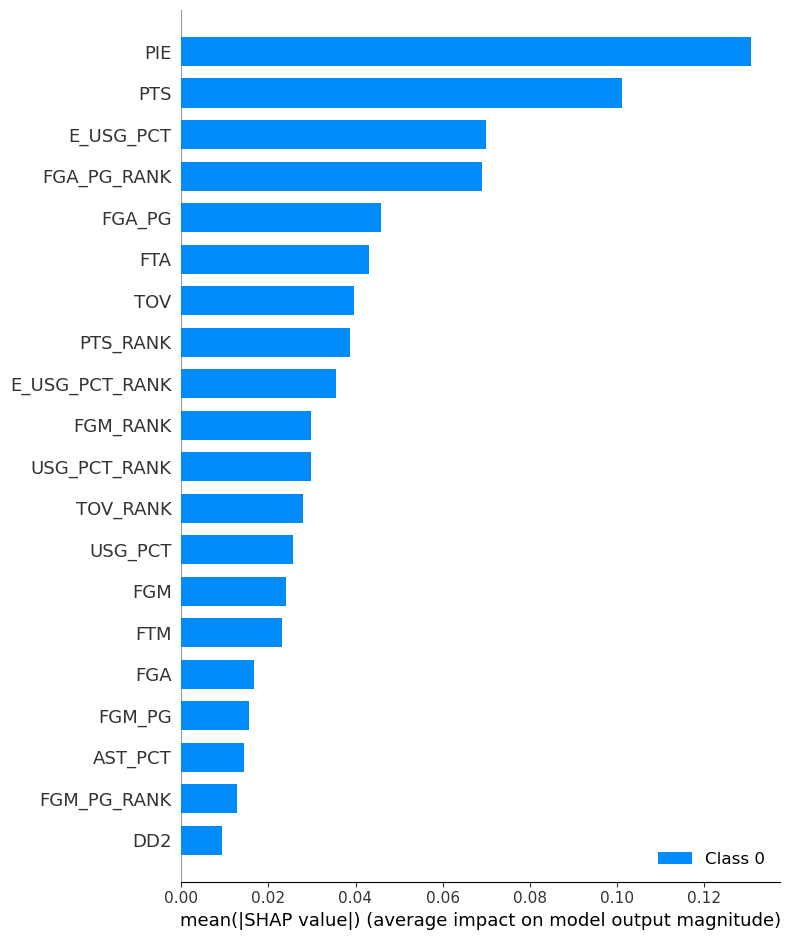

In [71]:
explainer = shap.KernelExplainer(model_nn.predict, nba_2000_18_new)
shap_nn = explainer.shap_values(nba_2019_22_new)
df = pd.DataFrame(nba_2019_22_new, columns=['FGM', 'FGA', 'FTM', 'FTA', 'TOV', 'PTS', 'DD2', 'FGM_RANK', 'TOV_RANK',
       'PTS_RANK', 'AST_PCT', 'USG_PCT', 'E_USG_PCT', 'PIE', 'FGM_PG',
       'FGA_PG', 'USG_PCT_RANK', 'E_USG_PCT_RANK', 'FGM_PG_RANK',
       'FGA_PG_RANK'])
feature_names = list(df.columns)


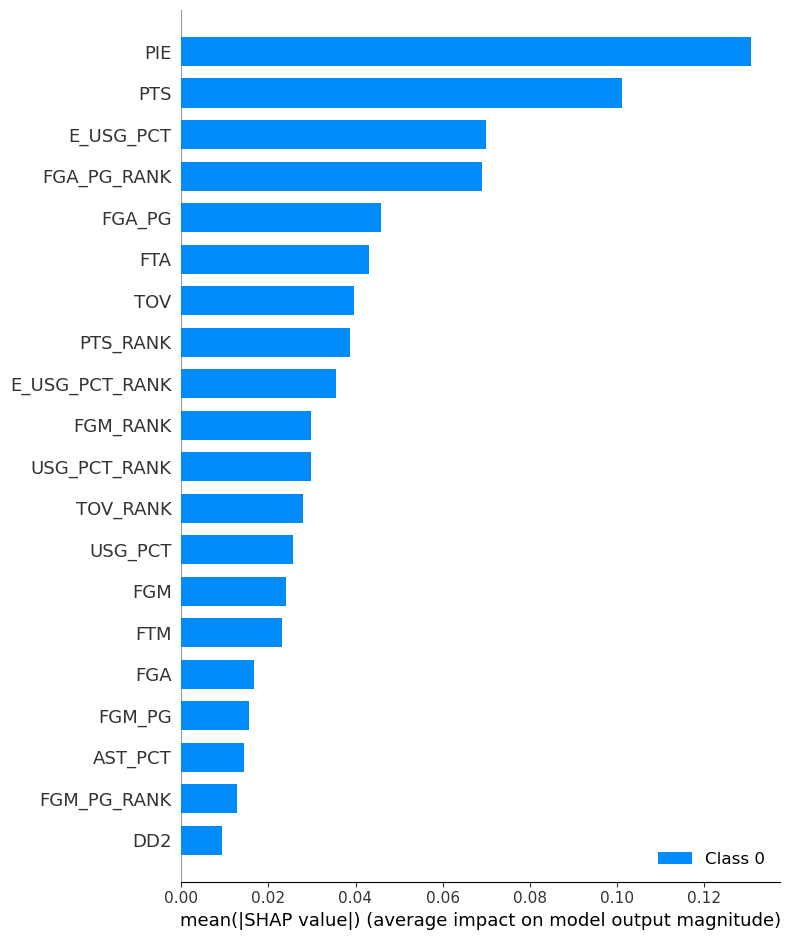

In [72]:
shap.summary_plot(shap_nn, df, feature_names=feature_names)

In [56]:
metrics = pd.DataFrame()
for key, value in test_values.items():
    metrics = testing_metrics(share_2019_22, value, metrics, key, '2019_22')
metrics

,Season,Model,RMSE,R_Square
0,2019_22,SVR,0.141,0.629
1,2019_22,Gradient Boosting,0.106,0.789
2,2019_22,Random Forest,0.127,0.700
3,2019_22,Neural Network,0.169,0.465


In [57]:
# nba 2023 MVP prediction
results = nba_2023[['PLAYER_NAME', 'TEAM_ABBREVIATION', 'season_id']]
mvp_prediction = {}
for key, model in trained_models.items():
    predicted = model.predict(nba_2023_new)
    predicted = predicted.reshape((nba_2023_new.shape[0],))
    

    results['Predicted MVP Share'] = pd.Series(predicted).values
    results = results.loc[(results['season_id'] == '2022-23')]
    # get top 10 results
    results_sorted = results.sort_values(by='Predicted MVP Share',
                                                ascending=False).reset_index(drop=True)
    mvp_prediction[key] = results_sorted[0:3]

1/1 [==============================] - 0s 21ms/step



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [58]:
# nba 2019 to 2022 MVP prediction
results = nba_2019_22[['PLAYER_NAME', 'TEAM_ABBREVIATION', 'season_id']]
test_season_list = ['2019-20', '2020-21', '2021-22']
model_past_mvp = {}
for key, model in trained_models.items():
    predicted = model.predict(nba_2019_22_new)
    predicted = np.clip(predicted, 0, 1)
    predicted = predicted.reshape((nba_2019_22_new.shape[0],))
    
    results['Predicted MVP Share'] = pd.Series(predicted).values
    past_mvp = {}
    for season in test_season_list:
        season_results = results.loc[(results['season_id'] == season)]
        season_results_sorted = season_results.sort_values(by='Predicted MVP Share',
                                                ascending=False).reset_index(drop=True)
        past_mvp[season] = season_results_sorted[0:3]
    
    model_past_mvp[key]  = past_mvp


3/3 [==============================] - 0s 918us/step



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [59]:
model_past_mvp

{'SVR': {'2019-20':              PLAYER_NAME TEAM_ABBREVIATION season_id  Predicted MVP Share
  0  Giannis Antetokounmpo               MIL   2019-20             1.000000
  1           James Harden               HOU   2019-20             0.539364
  2           LeBron James               LAL   2019-20             0.502902,
  '2020-21':              PLAYER_NAME TEAM_ABBREVIATION season_id  Predicted MVP Share
  0           Nikola Jokic               DEN   2020-21             0.639179
  1          Stephen Curry               GSW   2020-21             0.563400
  2  Giannis Antetokounmpo               MIL   2020-21             0.555905,
  '2021-22':              PLAYER_NAME TEAM_ABBREVIATION season_id  Predicted MVP Share
  0           Nikola Jokic               DEN   2021-22             0.955808
  1  Giannis Antetokounmpo               MIL   2021-22             0.695438
  2            Joel Embiid               PHI   2021-22             0.612226},
 'Gradient Boosting': {'2019-20':           

In [ ]:
trained_models